In [3]:
import numpy as np
import cv2
import matplotlib.pylab as plt
import random
import math 
from mpl_toolkits.axes_grid1 import ImageGrid


def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        
        plt.imshow(image, cmap="gray")   

# 1. 외관선 처리

((458.70343017578125, 381.97894287109375), (634.2526245117188, 202.513916015625), 44.29268264770508)
[[161 232]
 [302  88]
 [756 530]
 [614 675]]


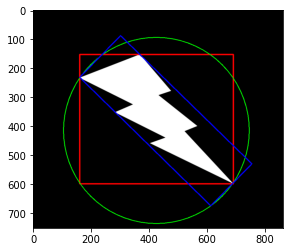

In [2]:
src = cv2.imread('shape.png')

gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

_, img_bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) #_ the returns we don't use
cnts, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


cnt = cnts[0]# first contour in contours
x, y, w, h = cv2.boundingRect(cnt) #return rect info
cv2.rectangle(src, (x,y), (x+w, y+h) , (0,0,255), 3)

(x, y), radius = cv2.minEnclosingCircle(cnt)#return min circle info
cv2.circle(src, (int(x),int(y)), int(radius), (0, 255, 0), 2)


rect = cv2.minAreaRect(cnt)#return min rect info
print(rect)#it prints also rotated angle
box = cv2.boxPoints(rect)#it converts rect info into recct points
box = np.int0(box)#converts obtained results into integers
print(box)
cv2.drawContours(src, [box], -1, (255,0,0), 4)  #box use it as list                     


imshow("", src)

# 2. 외곽선 근사화

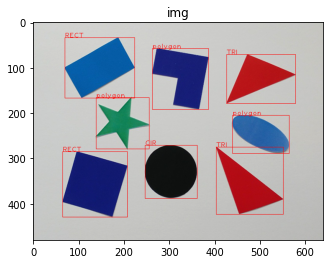

In [5]:
def setLabel(img, pts, label):
    (x, y, w, h) = cv2.boundingRect(pts)
    pt1 = (x, y)
    pt2 = (x + w, y + h)
    cv2.rectangle(img, pt1, pt2, (0, 0, 255), 1)
    cv2.putText(img, label, pt1, cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255))


img = cv2.imread('polygon.bmp', cv2.IMREAD_COLOR)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img_bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)#binary_inv due to our orginal image bg is white
contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

for pts in contours:
    #print(cv2.contourArea(pts))
    if cv2.contourArea(pts) < 400:# to avoid noise,where areas small ignore it
        continue

    approx = cv2.approxPolyDP(pts, cv2.arcLength(pts, True)*0.02, True)

    vtc = len(approx) #vertex

    if vtc == 3:
        setLabel(img, pts, 'TRI')#print( triangle)
    elif vtc == 4:
        setLabel(img, pts, 'RECT')#print(rect)
    else:#if not check it's circle
        lenth = cv2.arcLength(pts, True)
        area = cv2.contourArea(pts)
        ratio = 4. * math.pi * area / (lenth * lenth)

        if ratio > 0.85: #circle
            setLabel(img, pts, 'CIR')
        else :
            setLabel(img, pts, 'polygon')#print it as polygon

imshow('img', img)

# 3.활용

### 1) coin 검출

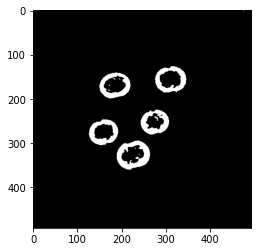

In [11]:
frame = cv2.imread("coin.png")
roi = frame.copy()
gray =  cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

gray_blur = cv2.GaussianBlur(gray, (7, 7), 0)
thresh = cv2.adaptiveThreshold(gray_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 45, 6)#inv our target is black and we want to make it white
imshow("",thresh)

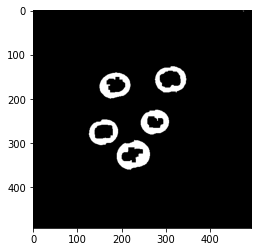

In [12]:
kernel = np.ones((3, 3), np.uint8)           
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=4) 
imshow("",closing)

In [14]:
cont_img = closing.copy()
contours, _ = cv2.findContours(cont_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

6


3668.5 102
2859.0 86
2690.5 89
3068.5 93
3207.0 98
3.5 5


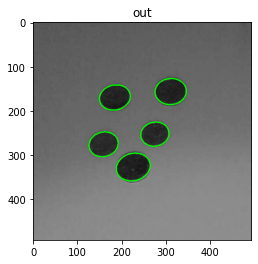

In [16]:
for cnt in contours:
    area = cv2.contourArea(cnt)
    print(area,len(cnt))
    if area < 2000 or area > 4000:
        continue
    if len(cnt) < 5:
        continue
    ellipse = cv2.fitEllipse(cnt)#fit ellipse
    cv2.ellipse(roi, ellipse, (0,255,0), 2)   
    
imshow("out", thresh)                               
imshow("out", cont_img)                               
imshow("out", roi)                               

### 2) 책 검출

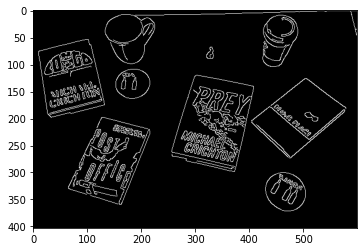

In [6]:
#detecting books
image = cv2.imread("book.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)
edged = cv2.Canny(gray, 10, 250)
imshow("",edged)

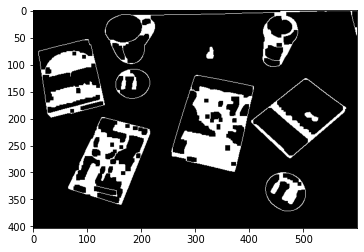

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
imshow("",closed)

In [8]:
cnts, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)# we use external for only outside bounding
total = 0
print(len(cnts))

8


8
4
4
4
8
8
4
10
I found 4 books in that image


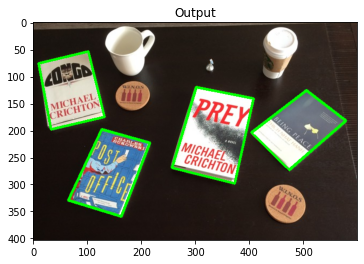

In [9]:
for c in cnts:
    peri = cv2.arcLength(c, True)#perimeter
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    print(len(approx))#aproximated countours

    if len(approx) == 4:
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 4)
        total += 1
print("I found {0} books in that image".format(total))
imshow("Output", image)

### 3) 명함영역 검출

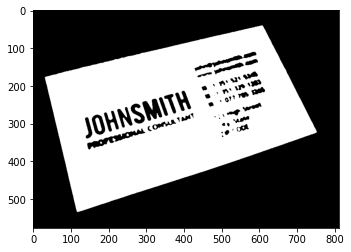

In [17]:
img = cv2.imread('namecard.png', 0)

gray = cv2.GaussianBlur(img, (13, 13), 0)
_,binary = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)
imshow("",binary)

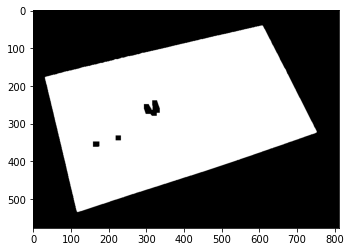

In [20]:
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, None,iterations=6)

#imshow("", img)
#plt.show()
imshow("", closed )

In [23]:
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

#print(contours) #contours info
print(len(contours))
print(len(contours[0]))#first contour


1
1129


In [25]:
card = contours[0]
peri = cv2.arcLength(card,True)
approx = cv2.approxPolyDP(card,0.02*peri,True).astype(np.float32)
print(approx)# 4 points

[[[609.  42.]]

 [[ 32. 177.]]

 [[116. 533.]]

 [[750. 324.]]]


[[ 6.05825456e-01 -1.42947580e-01  5.91530698e+00]
 [ 2.31194938e-01  9.88144288e-01 -1.82299777e+02]
 [-1.57107585e-04  4.79468952e-04  1.00000000e+00]]


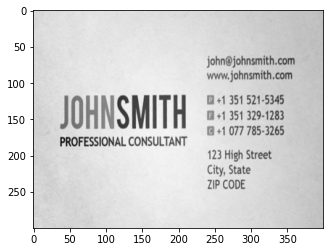

In [26]:
    
h = np.array([ [399,0],[0,0],[0,300],[399,300] ],np.float32) #anticlockise
approx = approx.reshape(4,2)

#perspectiveTransform makes perfect rect. it moves points to form right rectangle
transform = cv2.getPerspectiveTransform(approx,h)#parameters, 1.the coordinates we have 2. the coordinates we want to form
print(transform)
imshow("", cv2.warpPerspective(img,transform,(400,300))   ) #use wrapPer.. to create image of 400x300

### 4) 카드 패턴 검출

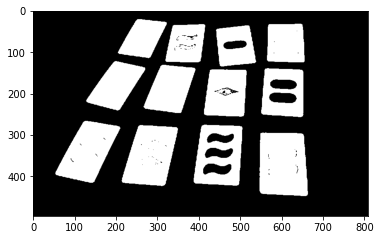

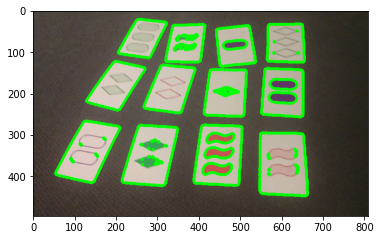

In [10]:

frame = cv2.imread('card.jpg')
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#Prepocessing
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(1,1),1000)
flag, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY)

imshow("", thresh); plt.show()
# Find contours
contours, _ = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

imgcont = img.copy()
cv2.drawContours(imgcont, contours, -1, (0,255,0), 5)





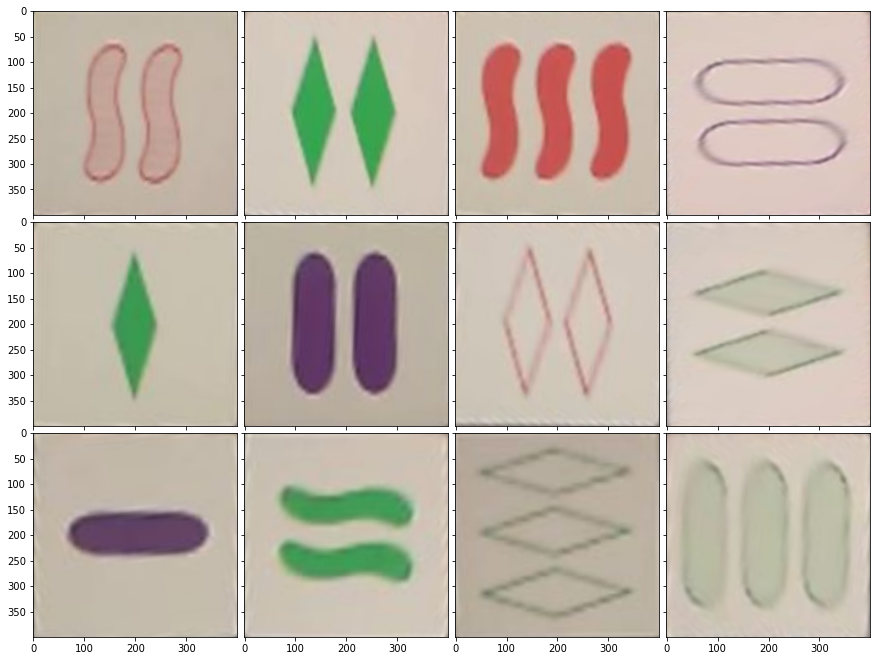

In [9]:
warp = []
for i in range(12):
    card = contours[i]
    peri = cv2.arcLength(card,True)
    approx = cv2.approxPolyDP(card,0.02*peri,True).astype(np.float32)
    
    h = np.array([ [0,0],[399,0],[399,399],[0,399] ],np.float32)
    approx = approx.reshape(4,2)
    transform = cv2.getPerspectiveTransform(approx,h)
    warp.append(cv2.warpPerspective(img,transform,(400,400)))

fig = plt.figure(1, (15,15))
grid = ImageGrid(fig, 111, 
                nrows_ncols = (3, 4),
                axes_pad=0.1, # pad between axes in inch.
                aspect=True, # do not force aspect='equal'
                )

for i in range(12):
    grid[i].imshow(warp[i])# The AxesGrid object work as a list of axes.
    

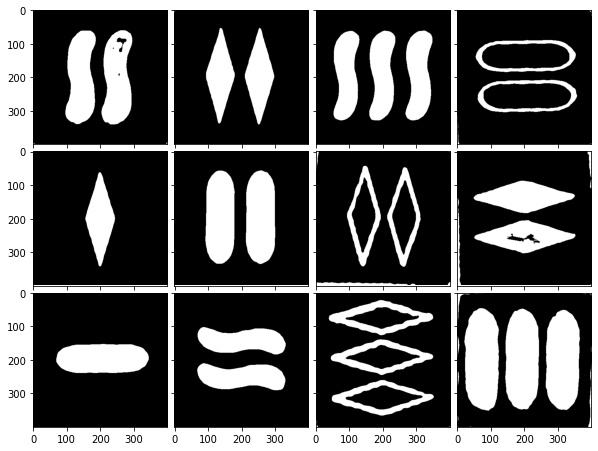

In [36]:
fig = plt.figure(1, (10,10))
grid = ImageGrid(fig, 111, 
                nrows_ncols = (3, 4), 
                axes_pad=0.1, 
                aspect=True,
                )
for i in range(12):
    image2 = cv2.bilateralFilter(warp[i],10,100,100)
    grey = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
    _, grey = cv2.threshold(grey, 0, 255, cv2.THRESH_BINARY_INV +cv2.THRESH_OTSU)
    '''
    contours, _ = cv2.findContours(grey,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    imgcont = image2.copy()
    cv2.drawContours(imgcont, contours, -1, (0,255,0), 5)
    
    total = 0
    for c in contours:
        peri = cv2.arcLength(c, True)#perimeter
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        print(len(approx))#aproximated countours

        if len(approx) == 4:
            cv2.drawContours(image, [approx], -1, (0, 255, 0), 4)
            total += 1
    
   '''

    grid[i].imshow(grey,cmap="gray") 
    #grid[i].imshow(imgcont) 


In [26]:
cv2.imshow(grey,cmap="gray") 

TypeError: imshow() missing required argument 'mat' (pos 2)

In [14]:
contours, _ = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

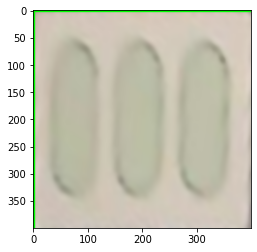

In [18]:
imgcont = image2.copy()
cv2.drawContours(image2, contours, -1, (0,255,0), 5)
plt.imshow(imgcont)

